In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import yaml
import matplotlib.pyplot as plt

In [2]:



def process_run_results(run_directory):
    run_directory = Path(run_directory)
    results_file = run_directory / 'results.csv'
    config_file = run_directory / '.hydra' / 'config.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    risk_thd = config['risk_thd']

    file = pd.read_csv(results_file)
    n = len(file)

    df = file.agg(['mean', 'std'])
    df = pd.concat([df.reward, df.penalty, df.steps], keys=['reward', 'penalty', 'steps'], axis=0).to_frame().T
    df[('reward', 'std')] /= np.sqrt(n)
    df[('penalty', 'std')] /= np.sqrt(n)
    df[('steps', 'std')] /= np.sqrt(n)
    df.index = [risk_thd]
    df.index.name = 'risk_thd'

    return df

class ExperimentLoader:
    OUTPUTS_PATH = '/var/data/xkurecka/rats/outputs'

    def __init__(self) -> None:
        self.exp_descs = None

    """
    Go through each file in the outputs directory (recursively) and find directories containing a folder called ".hydra".
    """
    def get_experiment_dirs(self):
        for root, dirs, files in os.walk(self.OUTPUTS_PATH):
            if '.hydra' in dirs:
                yield Path(root)
    
    def get_rats_version(self, experiment_dir: Path):
        try:
            with open(experiment_dir / 'rats_version.txt') as f:
                return f.read()
        except FileNotFoundError:
            return None

    def get_experiment_config(self, experiment_dir: Path):
        experiment_dir / '.hydra' / 'config.yaml'
        with open(experiment_dir / '.hydra' / 'config.yaml') as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
            config['experiment_dir'] = experiment_dir
            config['rats_version'] = self.get_rats_version(experiment_dir)
            return config
    
    """
    Pattern match .../YYYY-MM-DD/HH-MM-SS/...
    """
    def extract_date(self, experiment_dir: Path):
        date = None
        time = None
        for p in experiment_dir.parts:
            if len(p) == 10 and '-' in p:
                date = p
            if len(p) == 8 and '-' in p:
                time = p
        return date, time
    
    def load_experiment_descriptions(self, force=False):
        if self.exp_descs is not None and not force:
            return
        print('Loading experiment descriptions...')
        res = []
        for experiment_dir in self.get_experiment_dirs():
            config = self.get_experiment_config(experiment_dir)
            date, time = self.extract_date(experiment_dir)

            names = {
                'RAMCP': 'RAMCP',
                'DualRAMCP': 'DualRAMCP',
                'DualUCT': 'CC-POMCP',
                'ParetoUCT': 'ParetoUCT',
                'LambdaParetoUCT': 'LambdaParetoUCT',
            }

            agent_spec = names[config['agent']['class']]
            if 'exploration_constant' in config['agent']:
                agent_spec += '_d' + str(config['agent']['exploration_constant'])
            if 'risk_exploration_ratio' in config['agent']:
                agent_spec += '_r' + str(config['agent']['risk_exploration_ratio'])
            if 'sim_time_limit' in config['agent'] and config['agent']['sim_time_limit'] > 0:
                agent_spec += '_t' + str(config['agent']['sim_time_limit'])
            if 'num_sim' in config['agent'] and config['agent']['num_sim'] > 0:
                agent_spec += '_n' + str(config['agent']['num_sim'])
            if 'use_predictor' in config['agent']:
                agent_spec += f'_{"n"*(not config["agent"]["use_predictor"])}p'
            
            if 'slide_prob' in config['env'] and 'trap_prob' in config['env']:
                agent_spec = f's{config["env"]["slide_prob"]}t{config["env"]["trap_prob"]}_{agent_spec}'

            desc = {
                'experiment_dir': str(experiment_dir),
                'date': date,
                'time': time,
                'rats_version': self.get_rats_version(experiment_dir),
                'tag': config['metadata']['tag'],
                'agent': config['agent']['class'],
                'env': config['env']['class'],
                'thd': config['risk_thd'],
                'gamma': config['gamma'],
                'agent_spec': agent_spec,
            }
            if 'map' in config['env']:
                desc['map'] = config['env']['map']
            res.append(desc)
        self.exp_descs = pd.DataFrame(res)
        self.exp_descs.sort_values(by=['date', 'time', 'tag'], inplace=True, ascending=False)

        print('...done.')

    def simplified_exp_desc(self):
        return self.exp_descs[['date', 'time', 'tag', 'env']].drop_duplicates()

    # def exp_desc(self, date, time, tag):
    #     return self.exp_descs[(self.exp_descs.date == date) & (self.exp_descs.time == time) & (self.exp_descs.tag == tag)]

    def get_exp_data(self, date, time, tag):
        query = (self.exp_descs.date == date) & (self.exp_descs.tag == tag)
        # if time is pair or list
        if isinstance(time, list):
            query &= (self.exp_descs.time <= time[1]) & (self.exp_descs.time >= time[0])
        else:
            query &= self.exp_descs.time == time
        descs =  self.exp_descs[query]

        rows = []
        header = None
        for path in descs.experiment_dir:
            try:
                df = process_run_results(path)
                header = df.columns
            except FileNotFoundError:
                print('File not found')
                df = None
            rows.append(df)
        
        if header is None:
            return None

        rows = [
            df if df is not None else pd.DataFrame([[None] * len(header)], columns=header) for df in rows
        ]

        df = pd.concat(rows, axis=0)
        header = ['_'.join(h) for h in header]
        df = df.reset_index(drop=True)
        df.index = descs.index
        df.columns = header
        return pd.concat([descs, df], axis=1)


In [3]:
loader = ExperimentLoader()

In [4]:
loader.load_experiment_descriptions()

# loader.exp_descs = pd.read_csv('index.csv')

Loading experiment descriptions...


...done.


In [5]:
# data = loader.get_exp_data('2023-12-09', '09-48-03', 'ccpomcp2_FINAL')
# # data = data[data.thd > 0.4]
# data = data[['agent_spec', 'thd', 'penalty_mean']].pivot(index='agent_spec', columns='thd', values='penalty_mean')
# data.style.format(decimal='.', precision=2)
# data.columns = data.columns.astype(str)

# # data.index = data.index.str.replace('_', r'\_')
# # print(data.to_latex(float_format="{:0.2f}".format))

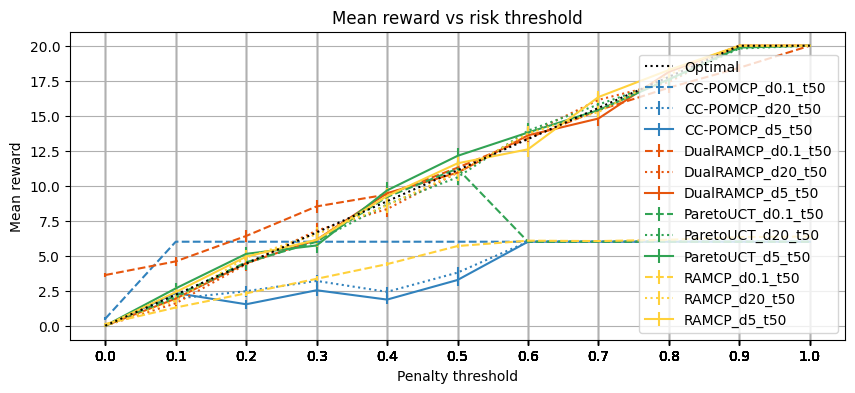

In [95]:
data = loader.get_exp_data('2023-12-09', '12-47-54', 'ccpomcp2_FINAL')

#sort by thd
data = data.sort_values(by='thd')

# plot, split by agent_spec with legend
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.set_title('Mean reward vs risk threshold')
# set x axis ticks
ax.set_xticks(data.thd)
# add grid
ax.grid()
ax.set_xlabel('Penalty threshold')
ax.set_ylabel('Mean reward')
ax.plot([0, 0.9, 1], [0, 20, 20], color='black', linestyle='dotted', label='Optimal', zorder=5)
for i, agent_spec in enumerate(sorted(data.agent_spec.unique())):
    agent_data = data[data.agent_spec == agent_spec]
    # plot with error bars
    # color gradient
    
    color_scheme = plt.get_cmap('tab20c')

    colors = [color_scheme(0), color_scheme(0.2), color_scheme(0.4),  '#ffd13b']
    styles = [
        'dashed', 'dotted', 'solid'
    ]

    
    # c = (i // 3) * 4 / 20 + (i % 3) / 20
    # print(c)
    color = colors[i // 3]
    style = styles[i % 3]
    # if i > 5:
    #     color = color_scheme((i+2)/10)
    ax.errorbar(agent_data.thd, agent_data.reward_mean, yerr=agent_data.reward_std, label=agent_spec, color=color, linestyle=style)
    # ax.errorbar(agent_data.thd, agent_data.reward_mean, yerr=agent_data.reward_std, label=agent_spec, color=color)
    # ax.plot(agent_data.thd, agent_data.reward_mean, label=agent_spec)

#plot diagonal line


ax.legend()

# plot in svg
plt.savefig('test.pdf', format='pdf')


In [132]:
data1 = loader.get_exp_data('2023-12-09', '12-47-54', 'ccpomcp2_FINAL')
data2 = loader.get_exp_data('2023-12-09', '21-22-55', 'final_7_FF')

In [152]:
def get_small_table(data, thd = 0.5):
    data = data[data['thd'] == thd]
    data = data[data['agent'] != 'DualRAMCP']
    try:
        data['d'] = data['agent_spec'].str.split('_').str[1].str[1:].astype(float).astype(str)
        data['agent'] = data['agent_spec'].str.split('_').str[0]
    except:
        data['d'] = data['agent_spec'].str.split('_').str[2].str[1:].astype(float).astype(str)
        data['agent'] = data['agent_spec'].str.split('_').str[1]

    # mean and max
    data = data[['agent', 'reward_mean', 'penalty_mean']].groupby('agent').mean()

    data = data.sort_values(by='agent')

    # data.set_index('agent', inplace=True)

    return data

df1 = get_small_table(data1, thd=0.5)
# print(df1)
df2 = get_small_table(data2, thd=0.1)
# print(df2)

df = pd.concat([df1, df2], axis=1, keys=['Experiment1', 'Experiment2'])

latex = df.to_latex(float_format="{:0.2f}".format)
latex = latex.replace('penalty_mean', 'penalty')
latex = latex.replace('reward_mean', 'reward')
latex = latex.replace('ParetoUCT', 'T-UCT')

print(latex)

\begin{tabular}{lrrrr}
\toprule
 & reward & penalty & reward & penalty \\
agent &  &  &  &  \\
\midrule
CC-POMCP & 4.35 & 0.31 & 2.22 & 0.12 \\
T-UCT & 11.32 & 0.50 & 3.94 & 0.10 \\
RAMCP & 9.41 & 0.52 & 3.43 & 0.16 \\
\bottomrule
\end{tabular}



0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7


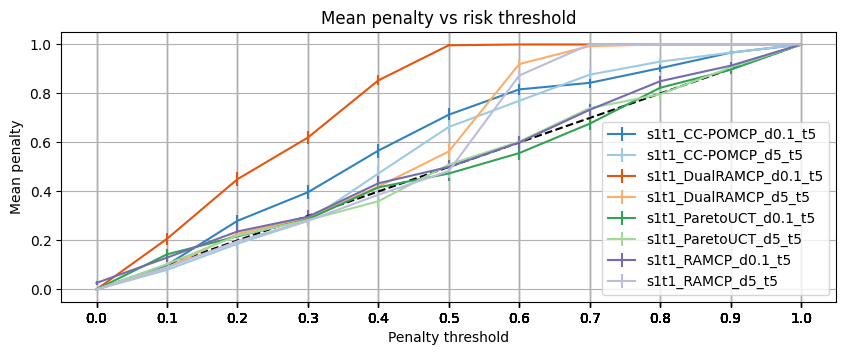

In [7]:
data = loader.get_exp_data('2023-12-09', '09-50-13', 'ramcp_FINAL')

#sort by thd
data = data.sort_values(by='thd')

# plot, split by agent_spec with legend
fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(111)
ax.set_title('Mean penalty vs risk threshold')
# set x axis ticks
ax.set_xticks(data.thd)
# add grid
ax.grid()
ax.set_xlabel('Penalty threshold')
ax.set_ylabel('Mean penalty')
for i, agent_spec in enumerate(sorted(data.agent_spec.unique())):
    agent_data = data[data.agent_spec == agent_spec]
    # plot with error bars
    # color gradient
    color_scheme = plt.get_cmap('tab20c')
    c = (i // 2) * 4 / 20 + (i % 2) * 2 / 20
    print(c)
    color = color_scheme(c)
    # if i > 5:
    #     color = color_scheme((i+2)/10)
    ax.errorbar(agent_data.thd, agent_data.penalty_mean, yerr=agent_data.penalty_std, label=agent_spec, color=color)
    # ax.plot(agent_data.thd, agent_data.reward_mean, label=agent_spec)

# add a diagonal line
ax.plot([0, 1], [0, 1], '--', color='black')

ax.legend()

# plot in svg
plt.savefig('test.pdf', format='pdf')


In [8]:
def get_exp_data(self, date, time, tag):
    query = (self.exp_descs.date == date) & (self.exp_descs.tag == tag)
    # if time is pair or list
    if isinstance(time, list):
        query &= (self.exp_descs.time <= time[1]) & (self.exp_descs.time >= time[0])
    else:
        query &= self.exp_descs.time == time
    descs =  self.exp_descs[query]

    rows = []
    header = None
    for path in descs.experiment_dir:
        try:
            df = process_run_results(path)
            header = df.columns
        except FileNotFoundError:
            # print('File not found')
            df = None
        rows.append(df)
    
    if header is None:
        return None

    rows = [
        df if df is not None else pd.DataFrame([[None] * len(header)], columns=header) for df in rows
    ]

    df = pd.concat(rows, axis=0)
    header = ['_'.join(h) for h in header]
    df = df.reset_index(drop=True)
    df.index = descs.index
    df.columns = header
    return pd.concat([descs, df], axis=1)

In [9]:
# get_exp_data(loader, '2023-12-09', ['19-15-23', '19-15-42'], 'final_1_FF') is None
# get_exp_data(loader, '2023-12-09', ['20-00-00', '21-00-00'], 'final_1_FF') is None

# print all experiments
experiments = loader.simplified_exp_desc()
experiments = experiments[experiments.date == '2023-12-10']

# print experiments so that the rows are not truncated
pd.set_option('display.max_rows', None)
print(experiments)

             date      time          tag      env
36852  2023-12-10  15-54-03  final_20_FF  Hallway
64932  2023-12-10  15-54-02  final_19_FF  Hallway
40632  2023-12-10  15-54-01  final_18_FF  Hallway
17412  2023-12-10  15-54-00  final_17_FF  Hallway
60792  2023-12-10  15-53-59  final_16_FF  Hallway
14172  2023-12-10  15-53-58  final_15_FF  Hallway
30912  2023-12-10  15-53-57  final_14_FF  Hallway
8052   2023-12-10  15-53-56  final_13_FF  Hallway
34152  2023-12-10  15-53-55  final_12_FF  Hallway
68484  2023-12-10  15-53-54  final_11_FF  Hallway
25512  2023-12-10  15-53-53  final_10_FF  Hallway
45672  2023-12-10  15-53-52   final_9_FF  Hallway
53592  2023-12-10  15-53-52   final_8_FF  Hallway
48552  2023-12-10  15-53-51   final_7_FF  Hallway
10932  2023-12-10  15-53-50   final_6_FF  Hallway
71184  2023-12-10  15-53-49   final_5_FF  Hallway
56112  2023-12-10  15-53-49   final_4_FF  Hallway
1980   2023-12-10  15-53-48   final_3_FF  Hallway
21372  2023-12-10  15-53-47   final_2_FF  Hallway


In [10]:
def process_data(df):
    df = df.sort_values(by='thd')
    # plot, split by agent_spec with legend
    fig = plt.figure(figsize=(10, 3.5))
    ax = fig.add_subplot(111)
    ax.set_title('Mean penalty vs risk threshold')
    # set x axis ticks
    ax.set_xticks(df.thd)
    # add grid
    ax.grid()
    ax.set_xlabel('Penalty threshold')
    ax.set_ylabel('Mean penalty')
    
    for i, agent_spec in enumerate(sorted(df.agent_spec.unique())):
        agent_data = df[df.agent_spec == agent_spec]
        color_scheme = plt.get_cmap('tab20c')
        c = i / len(df.agent_spec.unique())
        color = color_scheme(c)
        ax.errorbar(agent_data.thd, agent_data.penalty_mean, yerr=agent_data.penalty_std, label=agent_spec, color=color)
        if i > 10:
            break

    ax.legend()

    # plot to the screen
    plt.show()


In [11]:

dfs = []

for i in range(1, 21):
    # day = '2023-12-10'
    # time = ['12-00-00', '12-20-00']
    if i in [13, 14]:
        day = '2023-12-10'
        time = ['10-00-00', '12-00-00']
    else:
        day = '2023-12-09'
        time = ['21-00-00', '22-00-00']
    exp = f'final_{i}_FF'
    try:
        data = get_exp_data(loader, day, time, exp)
        data['exp'] = exp
        dfs.append(data)
        print("Done", i)
    except Exception as e:
        print(e)
        print("Error", i)

df = pd.concat(dfs, axis=0)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20


In [88]:
ci = 1.64

def get_is_safe(data, slide=None, trap=None, coef = -1):
    if slide is not None:
        data = data[data.slide == slide]
    if trap is not None:
        data = data[data.trap == trap]
    data['is_safe'] = data.penalty_mean + coef * ci * data.penalty_std <= data.thd
    return data.groupby('agent_spec').is_safe.sum()

def get_safety(data):
    data['safety'] = data[['thd', 'penalty_mean']].max(axis=1)
    data['safety'] -= data.thd
    # data['safety'] /= (data.thd)
    return data.groupby('agent_spec').safety.mean()

def get_safety_std(data):
    # data['norm_var'] = (data.penalty_std / (data.thd)) ** 2
    data['norm_std'] = data.penalty_std ** 2
    return data.groupby('agent_spec').norm_std.mean() ** 0.5

def get_safety_max_std(data):
    return data.groupby('agent_spec').penalty_std.max()

def get_values(data):
    cropped_penalty = data[['thd', 'penalty_mean']].max(axis=1)
    data['value'] = data['reward_mean'] #/ cropped_penalty * data['thd']
    mean_value = data.groupby(['experiment', 'thd']).value.mean()
    data['value'] /= data.apply(lambda row: mean_value[row.experiment, row.thd], axis=1)
    return data.groupby('agent_spec').value.mean()

def get_norm_constrained_value(data):
    data['is_safe'] = data.penalty_mean - ci * data.penalty_std <= data.thd
    cropped_penalty = data[['thd', 'penalty_mean']].max(axis=1)
    data['value'] = data['reward_mean'] / cropped_penalty * data['thd']
    mean_value = data.groupby(['experiment', 'thd']).value.max()
    data['value'] /= data.apply(lambda row: mean_value[row.experiment, row.thd], axis=1)
    data['value'] *= data.is_safe
    return data.groupby('agent_spec').value.mean()

def get_constrained_value(data):
    data['is_safe'] = data.penalty_mean - ci * data.penalty_std <= data.thd
    # cropped_penalty = data[['thd', 'penalty_mean']].max(axis=1)
    data['value'] = data['reward_mean'] #/ cropped_penalty * data['thd']
    data['value'] *= data.is_safe
    return data.groupby('agent_spec').value.mean()

data = df.copy()

env_conf = data.agent_spec.str.split('_').str[0]
data['slide'] = env_conf.str.split('s').str[1].str.split('t').str[0]
data['trap'] = env_conf.str.split('t').str[1]
data['d'] = data.agent_spec.str.split('_').str[-2]
data['t'] = data.agent_spec.str.split('_').str[-1]
data['experiment'] = data.tag + '_' + env_conf
data['agent_spec'] = data.agent_spec.str.split('_').str[1:].str.join('_')
data['algorithm'] = data.agent_spec.str.split('_').str[0]
data = data[data['algorithm'] != 'DualRAMCP']

results = []

for t in ['t1', 't2', 't5']:
    filtered_data = data[data.t == t].copy()

    is_safe0 = get_is_safe(filtered_data, coef=0)
    is_safe0_det = get_is_safe(filtered_data, coef=0, slide="0")
    is_safe0_stoch = get_is_safe(filtered_data, coef=0, slide="0.2")
    is_safeP = get_is_safe(filtered_data, coef=1)
    is_safe = get_is_safe(filtered_data)
    is_safe_det = get_is_safe(filtered_data, slide="0")
    is_safe_stoch = get_is_safe(filtered_data, slide="0.2")
    safety = get_safety(filtered_data)
    values = get_values(filtered_data)
    ncv = get_norm_constrained_value(filtered_data)
    cv = get_constrained_value(filtered_data)
    std = get_safety_std(filtered_data)
    max_std = get_safety_max_std(filtered_data)

    steps = filtered_data.groupby('agent_spec').steps_mean.mean()

    # concat
    res = pd.concat([
                    filtered_data.groupby('agent_spec').t.first(),
                    filtered_data.groupby('agent_spec').algorithm.first(),
                    filtered_data.groupby('agent_spec').d.first(),
                    is_safe0.astype(str), ' ($' + is_safe0_det.astype(str) + ' \\mid ' + is_safe0_stoch.astype(str) + '$)',
                    is_safe.astype(str), ' ($' + is_safe_det.astype(str) + ' \\mid ' + is_safe_stoch.astype(str) + '$)',
                     ncv], axis=1)
    res.columns = [
                    't', 'algorithm', 'd',
                    'is_safe_emp','',
                    'is_safe_conf','',
                    'ncv']

    res = res.sort_values(by='agent_spec', ascending=False)
    # res = res[res.is_safe > 300]

    res.index = res.index.str.split('_').str[:-1].str.join('\_')
    results.append(res)

results = pd.concat(results, axis=0, keys=['t1', 't2', 't5'])
results['d'] = results['d'].str.replace('d', '').astype(float)
results['t'] = results['t'].str.replace('t', '')
results = results.sort_values(by=['algorithm', 't', 'd'])
results['d'] = results['d'].astype(str)
results = results.set_index(keys=['algorithm', 't', 'd'])
results

/tmp/ipykernel_2949789/1582855430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_safe'] = data.penalty_mean + coef * ci * data.penalty_std <= data.thd
/tmp/ipykernel_2949789/1582855430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_safe'] = data.penalty_mean + coef * ci * data.penalty_std <= data.thd
/tmp/ipykernel_2949789/1582855430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

is_safe_emp                   is_safe_conf  \
algorithm t d                                                 
CC-POMCP  1 0.1          123    ($97 \mid 26$)          146   
            5.0          132   ($101 \mid 31$)          160   
            20.0         127    ($95 \mid 32$)          150   
          2 0.1          122    ($94 \mid 28$)          158   
            5.0          157   ($118 \mid 39$)          183   
            20.0         148   ($111 \mid 37$)          177   
          5 0.1          120    ($98 \mid 22$)          161   
            5.0          169   ($124 \mid 45$)          209   
            20.0         184   ($130 \mid 54$)          221   
ParetoUCT 1 0.1          160   ($122 \mid 38$)          275   
            5.0          140   ($110 \mid 30$)          255   
            20.0         137   ($112 \mid 25$)          244   
          2 0.1          203   ($142 \mid 61$)          338   
            5.0          193   ($131 \mid 62$)          329   
            20.0         176   ($129 \mid 47$)          314   
          5 0.1          241   ($145 \mid 96$)          369   
            5.0          245   ($156 \mid 89$)          373   
            20.0         216   ($136 \mid 80$)          361   
RAMCP     1 0.1           35    ($24 \mid 11$)           69   
            5.0          159   ($124 \mid 35$)          255   
            20.0         143   ($106 \mid 37$)          241   
          2 0.1           36    ($22 \mid 14$)           78   
            5.0          178   ($130 \mid 48$)          299   
            20.0         164   ($123 \mid 41$)          277   
          5 0.1           48    ($27 \mid 21$)           91   
            5.0          215   ($139 \mid 76$)          326   
            20.0         203   ($141 \mid 62$)          305   

                                          ncv  
algorithm t d                                  
CC-POMCP  1 0.1     ($115 \mid 31$)  0.184911  
            5.0     ($119 \mid 41$)  0.145287  
            20.0    ($109 \mid 41$)  0.130317  
          2 0.1     ($122 \mid 36$)  0.205591  
            5.0     ($131 \mid 52$)  0.173886  
            20.0    ($125 \mid 52$)  0.156715  
          5 0.1     ($127 \mid 34$)  0.229083  
            5.0     ($146 \mid 63$)  0.221546  
            20.0    ($146 \mid 75$)  0.210270  
ParetoUCT 1 0.1     ($177 \mid 98$)  0.604936  
            5.0     ($175 \mid 80$)  0.577014  
            20.0    ($167 \mid 77$)  0.542305  
          2 0.1    ($189 \mid 149$)  0.720461  
            5.0    ($193 \mid 136$)  0.708984  
            20.0   ($190 \mid 124$)  0.684871  
          5 0.1    ($194 \mid 175$)  0.758153  
            5.0    ($197 \mid 176$)  0.790529  
            20.0   ($195 \mid 166$)  0.740176  
RAMCP     1 0.1      ($48 \mid 21$)  0.181669  
            5.0     ($182 \mid 73$)  0.578557  
            20.0    ($173 \mid 68$)  0.542386  
          2 0.1      ($48 \mid 30$)  0.204049  
            5.0    ($196 \mid 103$)  0.652940  
            20.0    ($183 \mid 94$)  0.593841  
          5 0.1      ($51 \mid 40$)  0.246580  
            5.0    ($195 \mid 131$)  0.712503  
            20.0   ($196 \mid 109$)  0.652653

In [94]:
latex = results.to_latex(float_format="{:0.2f}".format)

# latex = latex.replace(f'is_safe', f'$\\sat$')
# for i in range(1, 5):
#     latex = latex.replace(f'is_safe{i}', f'$\\sat{i}$')
latex = latex.replace('is_safe_emp', '$E\\sat$')
latex = latex.replace('is_safe_conf', '$E\\sat$')
latex = latex.replace('CC-POMCP', '\\rotatebox{90}{CC-POMCP}')
latex = latex.replace('ParetoUCT', '\\rotatebox{90}{T-UCT}')
latex = latex.replace('RAMCP', '\\rotatebox{90}{RAMCP}')
latex = latex.replace('ncv', '$\\ncv$')
latex = latex.replace('[t]', '')
latex = latex.replace('\\cline{1-8} \\cline{2-8}', '\\cline{1-8}')

latex = latex.split('\\midrule')[1]

latex = """
\\begin{tabular}{p{0.4cm}p{0.4cm}p{0.4cm}p{0.4cm}p{1.45cm}p{0.4cm}p{1.65cm}r}
\\toprule
& $t(\\text{ms})$ & $d$ & $E\\sat_{emp}$ & & $E\\sat_{conf}$ & & $\\ncv$ \\\\
\\midrule
""" + latex

print(latex)

# for t in [1, 2, 5]:
#     latex = latex.replace(f't{t}'+'}', f'${t}\\text{{ms}}$' + '}')

# print(latex)






\begin{tabular}{p{0.4cm}p{0.4cm}p{0.4cm}p{0.4cm}p{1.45cm}p{0.4cm}p{1.65cm}r}
\toprule
& $t(\text{ms})$ & $d$ & $E\sat_{emp}$ & & $E\sat_{conf}$ & & $\ncv$ \\
\midrule

\multirow{9}{*}{\rotatebox{90}{CC-POMCP}} & \multirow{3}{*}{1} & 0.1 & 123 &  ($97 \mid 26$) & 146 &  ($115 \mid 31$) & 0.18 \\
 &  & 5.0 & 132 &  ($101 \mid 31$) & 160 &  ($119 \mid 41$) & 0.15 \\
 &  & 20.0 & 127 &  ($95 \mid 32$) & 150 &  ($109 \mid 41$) & 0.13 \\
\cline{2-8}
 & \multirow{3}{*}{2} & 0.1 & 122 &  ($94 \mid 28$) & 158 &  ($122 \mid 36$) & 0.21 \\
 &  & 5.0 & 157 &  ($118 \mid 39$) & 183 &  ($131 \mid 52$) & 0.17 \\
 &  & 20.0 & 148 &  ($111 \mid 37$) & 177 &  ($125 \mid 52$) & 0.16 \\
\cline{2-8}
 & \multirow{3}{*}{5} & 0.1 & 120 &  ($98 \mid 22$) & 161 &  ($127 \mid 34$) & 0.23 \\
 &  & 5.0 & 169 &  ($124 \mid 45$) & 209 &  ($146 \mid 63$) & 0.22 \\
 &  & 20.0 & 184 &  ($130 \mid 54$) & 221 &  ($146 \mid 75$) & 0.21 \\
\cline{1-8}
\multirow{9}{*}{\rotatebox{90}{T-UCT}} & \multirow{3}{*}{1} & 0.1 & 160